In [1]:
import numpy as np
import pandas as pd

import pymc as pm
import xarray as xr

from pymc_marketing.clv import utils
from pymc_marketing.clv import ParetoNBDModel
from pymc_extras.prior import Prior

from pymc_marketing.clv import utils, plotting

In [2]:
import pytensor

#set flag to fix open issue
pytensor.config.cxx = '/usr/bin/clang++'

Create a simple dataset for testing:

In [3]:
d = [
    [1, "2015-01-01", 1],
    [1, "2015-02-06", 2],
    [2, "2015-01-01", 2],
    [3, "2015-01-01", 3],
    [3, "2015-01-02", 1],
    [3, "2015-01-05", 5],
    [4, "2015-01-16", 6],
    [4, "2015-02-02", 3],
    [4, "2015-02-05", 3],
    [4, "2015-02-05", 2],
    [5, "2015-01-16", 3],
    [5, "2015-01-17", 1],
    [5, "2015-01-18", 8],
    [6, "2015-02-02", 5],
]
test_data = pd.DataFrame(d, columns=["id", "date", "monetary_value"])

Note customer 4 made two purchases on 2015-02-05. 

`_find_first_transactions` flags the first purchase each customer has made, which must be excluded for modeling. It is called internally by `rfm_summary`.

In [4]:
utils._find_first_transactions(
    transactions=test_data, 
    customer_id_col = "id", 
    datetime_col = "date",
    #monetary_value_col = "monetary_value", 
    #datetime_format = "%Y%m%d",
).reindex()

,id,date,first
0,1,2015-01-01,True
1,1,2015-02-06,False
2,2,2015-01-01,True
3,3,2015-01-01,True
4,3,2015-01-02,False
5,3,2015-01-05,False
6,4,2015-01-16,True
7,4,2015-02-02,False
8,4,2015-02-05,False
10,5,2015-01-16,True


Notice how **9** is missing from the dataframe index. Multiple transactions in the same time period are treated as a single purchase, so the indices for those additional transactions are skipped. 

`rfm_summary` is the primary data preprocessing step for CLV modeling in the continuous, non-contractual domain:

In [5]:
rfm_df = utils.rfm_summary(
    test_data, 
    customer_id_col = "id", 
    datetime_col = "date", 
    monetary_value_col = "monetary_value",
    observation_period_end = "2015-02-06",
    datetime_format = "%Y-%m-%d",
    time_unit = "W",
    include_first_transaction=True,
)

rfm_df.head()

,customer_id,frequency,recency,monetary_value
0,1,2.0,0.0,1.5
1,2,1.0,5.0,2.0
2,3,2.0,4.0,4.5
3,4,2.0,0.0,7.0
4,5,1.0,3.0,12.0


For MAP fits and covariate models, `rfm_train_test_split` can be used to evaluate models on unseen data. It is also useful for identifying the impact of a time-based event like a marketing campaign.

In [6]:
train_test = utils.rfm_train_test_split(
    test_data, 
    customer_id_col = "id", 
    datetime_col = "date", 
    train_period_end = "2015-02-01",
    monetary_value_col = "monetary_value",
)

train_test.head()

,customer_id,frequency,recency,T,monetary_value,test_frequency,test_monetary_value,test_T
0,1,0.0,0.0,31.0,0.0,1.0,2.0,5.0
1,2,0.0,0.0,31.0,0.0,0.0,0.0,5.0
2,3,2.0,4.0,31.0,3.0,0.0,0.0,5.0
3,4,0.0,0.0,16.0,0.0,2.0,4.0,5.0
4,5,2.0,2.0,16.0,4.5,0.0,0.0,5.0


`rfm_segments` will assign customer to segments based on their recency, frequency, and monetary value. It uses a quartile-based RFM score approach that is very computationally efficient, but defining custom segments is a rather subjective exercise. The returned dataframe also cannot be used for modeling because it does not zero out the initial transactions.

In [7]:
segments = utils.rfm_segments(
    test_data, 
    customer_id_col = "id", 
    datetime_col = "date", 
    monetary_value_col = "monetary_value",
    observation_period_end = "2015-02-06",
    datetime_format = "%Y-%m-%d",
    time_unit = "W",
)

/Users/coltallen/Projects/pymc-marketing/pymc_marketing/clv/utils.py:707: UserWarning: RFM score will not exceed 2 for f_quartile. Specify a custom segment_config
  warnings.warn(


# Plotting
`expected_cumulative_transactions` and all other plotting functions require a fitted model. Test with both MAP and full posteriors:

In [39]:
url_cdnow = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/cdnow_transactions.csv"
raw_trans = pd.read_csv(url_cdnow)

rfm_data = utils.rfm_summary(
    raw_trans, 
    customer_id_col = "id", 
    datetime_col = "date", 
    datetime_format = "%Y%m%d",
    time_unit = "W",
    observation_period_end = "19970930",
    #time_scaler = 7,
)

rfm_train_test = utils.rfm_train_test_split(
    raw_trans, 
    customer_id_col = "id", 
    datetime_col = "date", 
    train_period_end = "19970701",
    datetime_format = "%Y%m%d",
    time_unit = "W",
    test_period_end = "19970930",
)

t=rfm_data["T"].max().astype(int)
t_start_eval = rfm_train_test["T"].max()

pnbd_split = ParetoNBDModel(data=rfm_data)
pnbd_split.fit()

Output()

Inference data with groups:
	> posterior
	> observed_data
	> fit_data

### Expected Cumulative Purchases

In [36]:
df_cum = utils._expected_cumulative_transactions(
    model=pnbd_split,
    transactions=raw_trans,
    customer_id_col="id",
    datetime_col="date",
    t=t,
    datetime_format="%Y%m%d",
    time_unit="W",
    set_index_date=True,
)

df_cum.head()

,actual,predicted
1996-12-30/1997-01-05,0,4.286469
1997-01-06/1997-01-12,3,15.595394
1997-01-13/1997-01-19,17,33.947389
1997-01-20/1997-01-26,44,59.853467
1997-01-27/1997-02-02,67,93.519782


If doing a train/test split, or studying time interventions like marketing campaigns, `plot_expected_purchases_over_time` can be used for easy visual interpretation.

<Axes: title={'center': 'Tracking Cumulative Transactions'}, xlabel='Time Periods', ylabel='Purchases'>

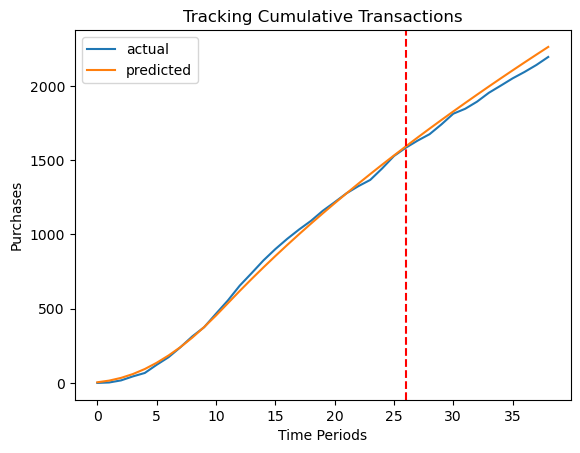

In [41]:
plotting.plot_expected_purchases_over_time(
    model=pnbd_split,
    purchase_history=raw_trans,
    customer_id_col="id",
    datetime_col="date",
    t=t,
    t_start_eval = t_start_eval,
    datetime_format="%Y%m%d",
    time_unit="W",
    plot_cumulative=True,
)

In [ ]:
plotting.plot_expected_purchases_ppc(map_pnbd, ppc='prior');

In [ ]:
plotting.plot_expected_purchases_ppc(map_pnbd, ppc='posterior');

Now fit a model by sampling from the posterior distributions:

In [ ]:
pnbd = ParetoNBDModel(data=rfm_data)

pnbd.build_model()
with pnbd.model:
    pnbd.idata = pm.sample(
        step=pm.DEMetropolisZ(),
        tune=2500,
        draws=3000,
        idata_kwargs={"log_likelihood": True},
    )

In [14]:
pnbd.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,14.596,1.114,12.445,16.640,0.042,0.030,712.0,1280.0,1.01
beta,12.043,3.800,5.029,18.742,0.127,0.090,862.0,1294.0,1.00
r,0.640,0.054,0.545,0.742,0.002,0.001,894.0,1132.0,1.01
s,0.529,0.105,0.340,0.729,0.004,0.003,842.0,1553.0,1.01


In [15]:
# thin_fit_result is not supported with external sampler fits in `ParetoNBDModel`!
#pnbd.idata = pnbd.thin_fit_result(keep_every=3)

pnbd.idata = pnbd.idata.isel(draw=slice(None, None, 3)).copy()
pnbd.idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

<Axes: title={'center': 'Tracking Cumulative Transactions'}, xlabel='Time Periods', ylabel='Purchases'>

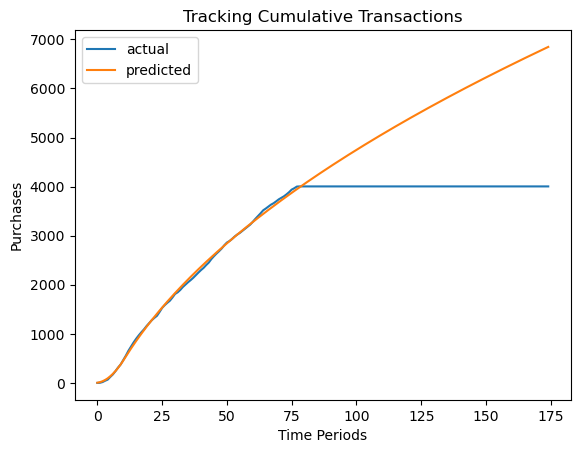

In [16]:
plotting.plot_expected_purchases(
    model=pnbd,
    purchase_history=raw_trans,
    customer_id_col="id",
    datetime_col="date",
    t=25*7,
    datetime_format="%Y%m%d",
    time_unit="W",
    plot_cumulative=True,
)

Sampling: [alpha, beta, r, recency_frequency, s]


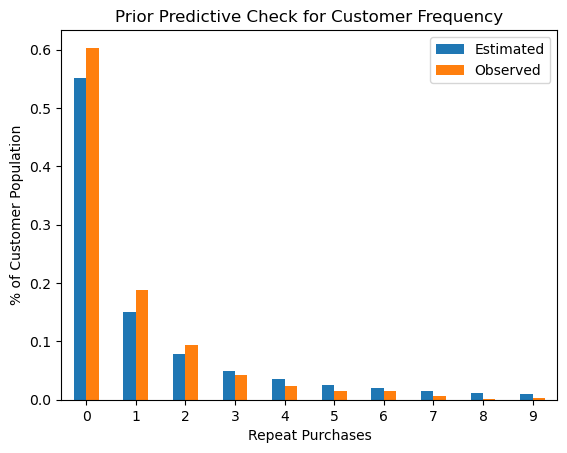

In [17]:
plotting.plot_expected_purchases_ppc(pnbd, ppc='prior');

Sampling: [recency_frequency]


Output()

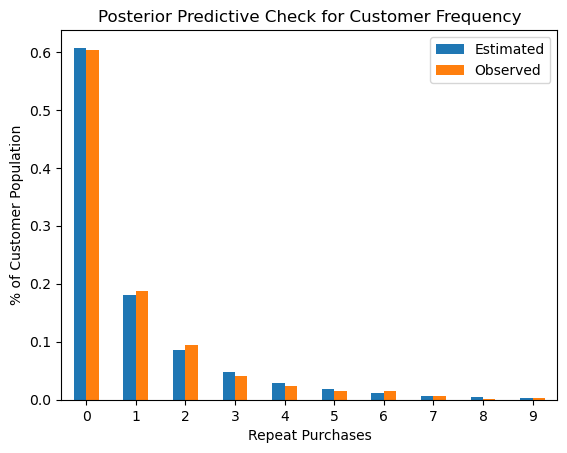

In [18]:
plotting.plot_expected_purchases_ppc(pnbd, ppc='posterior');

Adding HDIs to `plot_purchase_pmf` requires value counts to be grouped coordinate-wise across a dimension like `draws`, which may not be supported in `xarray`. `arviz.hdi` can then be applied across all value counts for interval estimation.

In [19]:
# keep n_samples=1
pnbd.distribution_new_customer_recency_frequency(
        random_seed=45,
        n_samples=1,
    ).sel(obs_var="frequency")

Sampling: [recency_frequency]


Output()

<xarray.DataArray 'recency_frequency' (chain: 4, draw: 1000, customer_id: 2357)> Size: 75MB
array([[[ 2.,  0.,  0., ...,  7.,  1.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  2.,  0., ...,  0.,  4.,  0.],
        ...,
        [ 8.,  2., 10., ...,  7.,  0.,  1.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  1., ...,  2.,  6.,  0.]],

       [[ 1.,  3.,  0., ...,  1.,  2.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  3.,  0., ...,  0.,  2.,  4.],
        ...,
        [ 2.,  0.,  0., ...,  0.,  2.,  0.],
        [ 0.,  0.,  4., ...,  0.,  1.,  3.],
        [ 0.,  0.,  0., ...,  0.,  0.,  2.]],

       [[ 1.,  0.,  1., ...,  3.,  0.,  0.],
        [ 1.,  1.,  0., ...,  3.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  2.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  6.,  0.],
        [ 1.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.]],

       [[ 1.,  0.,  0., ...,  0.,  0.,  1.],
        [ 3.,  0.,  0., ...,  2.,  0.,  0.],
        [ 4.,  1.,  0., ...,  2.,  5.,  0.],
        ...,
        [ 1.,  0.,  3., ...,  2.,  3.,  0.],
        [ 0.,  0.,  1., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  2.,  0.,  0.]]])
Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 8kB 0 3 6 9 12 15 ... 2985 2988 2991 2994 2997
  * customer_id  (customer_id) int64 19kB 1 2 3 4 5 ... 2353 2354 2355 2356 2357
    obs_var      <U9 36B 'frequency'

In [20]:
import pymc as pm
import xarray as xr

# TODO: Add build_model() before a prior predictive check
pnbd.build_model()
with pnbd.model:
    prior_idata = pm.sample_prior_predictive(random_seed=45, draws=100)

# obs_var must be obtained from  prior_idata in case of an unfit model
obs_freq = prior_idata.observed_data["recency_frequency"].sel(obs_var="frequency")
ppc_freq = prior_idata.prior_predictive["recency_frequency"].sel(obs_var="frequency")#.mean(("chain","draw"))
#ppc_freq = prior_idata.prior_predictive["recency_frequency"].sel(obs_var="frequency").mean(("chain","draw"))#.rename({o

ppc_df = ppc_freq.to_dataframe()['recency_frequency'].value_counts(normalize=True).sort_index() * 100

# Percentages are the only way to compare actual counts to chain*draw simulated counts
# merged_xr.to_dataframe()["recency_frequency"].value_counts(normalize=True) * 100
# merged_xr.to_dataframe()["ppc_mean"].value_counts(normalize=True) * 100

Sampling: [alpha, beta, r, recency_frequency, s]


<Axes: >

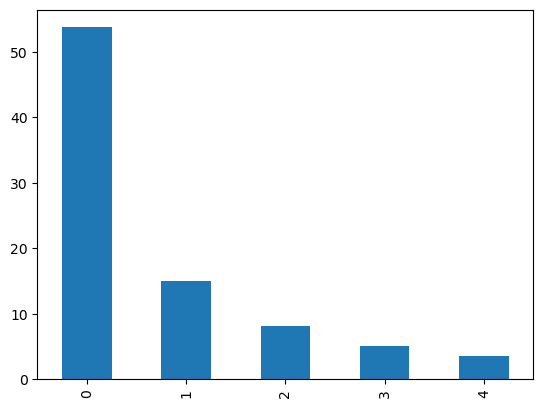

In [21]:
ppc_df.reset_index()['proportion'].head(5).plot(kind='bar')

In [22]:
from xarray.groupers import UniqueGrouper

# This will do value counts for entire DataArray
#ppc_freq.groupby(ppc_freq).count()
#ppc_freq.groupby(chain=UniqueGrouper()).count()

#value_counts = xr.DataArray(np.bincount(ppc_freq.values), dims="value")
#np.bincount(ppc_freq.values)
xr.DataArray([1, 2, 2, 3, 3, 3], dims="x")
# but what about individual customers?
# create a value count coordinate
# prior_idata.prior_predictive.coords["value_counts"] = ppc_freq.groupby(ppc_freq).count()["ppc_mean"].values
# ppc_freq = prior_idata.rename_vars({"recency_frequency":"ppc_mean"}).prior_predictive["ppc_mean"]#.sel(obs_var="frequency")#.mean(("chain","draw"))
# ppc_freq
# prior_idata.prior_predictive.groupby(value_counts=UniqueGrouper()).count().sel(obs_var="frequency")
#prior_idata.prior_predictive.groupby("customer_id").count()
#prior_idata# 
#
# #ppc_freq.coords["grouped_customer"] 
#ppc_freq.groupby(draw=UniqueGrouper()).count()


<xarray.DataArray (x: 6)> Size: 48B
array([1, 2, 2, 3, 3, 3])
Dimensions without coordinates: x

In [23]:
from arviz.stats import hdi

calc_hdi = hdi(
    ary=prior_idata,
    hdi_prob=.9, #param
    group='prior_predictive', #posterior
).sel(obs_var='frequency')

hdi_lo = calc_hdi.sel(hdi='lower').to_array().squeeze()
hdi_hi = calc_hdi.sel(hdi='higher').to_array().squeeze()

# TODO: Join back to ppc_freq & obs var
hdi_hi

<xarray.DataArray (customer_id: 2357)> Size: 19kB
array([6., 5., 9., ..., 6., 6., 6.])
Coordinates:
  * customer_id  (customer_id) int64 19kB 1 2 3 4 5 ... 2353 2354 2355 2356 2357
    obs_var      <U9 36B 'frequency'
    hdi          <U6 24B 'higher'
    variable     <U17 68B 'recency_frequency'